In [1]:
import pandas as pd
import numpy as np
import os
import csv
from zipfile import ZipFile
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.optimize import minimize
from transformers import AutoModel, AutoTokenizer, XLMRobertaModel
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence
from typing import Dict, List, Tuple, Optional
import random
from torch.utils.data import random_split
import logging
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class DataLoaders:
    def __init__(self):
        self.setup_paths()
        self.setup_logging()

    def setup_logging(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def setup_paths(self):
        self.path_dev = 'dev/'
        self.path_train = 'train/'
        self.path_test = 'test/'
        self.path_output = 'answer/'
        self.path_testh = 'testh/'

        for path in [self.path_dev, self.path_train, self.path_test, self.path_output, self.path_testh]:
            if not os.path.exists(path):
                os.makedirs(path)

    def extract_zip_files(self):
        # Extract dev.zip
        if not os.listdir(self.path_dev):
            with ZipFile('dev.zip', 'r') as dev:
                dev.extractall(self.path_dev)

        # Extract train.zip
        if not os.listdir(self.path_train):
            with ZipFile('train.zip', 'r') as train:
                train.extractall(self.path_train)

        # Extract test.zip
        if not os.listdir(self.path_test):
            with ZipFile('test.zip', 'r') as test:
                test.extractall(self.path_test)

        # Extract testh.zip
        if not os.listdir(self.path_testh):
            with ZipFile('test_hidden1.zip', 'r') as testh:
                testh.extractall(self.path_testh)

    def load_tsv_files(self):
        languages = os.listdir(self.path_train)
        self.logger.info(f"Found languages: {languages}")

        # Initialize file paths
        label_file_paths_train = []
        uses_file_paths_train = []
        label_file_paths_dev = []
        uses_file_paths_dev = []
        instance_file_paths_test = []
        uses_file_paths_test = []
        label_file_paths_test = []
        

        for lang in languages:
            label_file_paths_train.append(f"{self.path_train}{lang}/labels.tsv")
            uses_file_paths_train.append(f"{self.path_train}{lang}/uses.tsv")
            label_file_paths_dev.append(f"{self.path_dev}{lang}/labels.tsv")
            uses_file_paths_dev.append(f"{self.path_dev}{lang}/uses.tsv")
            instance_file_paths_test.append(f"{self.path_test}{lang}/instances.tsv")
            uses_file_paths_test.append(f"{self.path_test}{lang}/uses.tsv")
            label_file_paths_test.append(f"{self.path_testh}{lang}/labels.tsv")
        paths = {
            'train_labels_list': label_file_paths_train,
            'train_uses_list': uses_file_paths_train,
            'dev_labels_list': label_file_paths_dev,
            'dev_uses_list': uses_file_paths_dev,
            'test_uses_list': uses_file_paths_test,
            'test_instances_list': instance_file_paths_test,
            'test_labels_list': label_file_paths_test
        }

        data_dict = {key: [] for key in paths.keys()}

        for save_path, path_list in paths.items():
            for path in path_list:
                with open(path, encoding='utf-8') as tsvfile:
                    language = path.split('/')[1]
                    reader = csv.DictReader(tsvfile, delimiter='\t',
                                         quoting=csv.QUOTE_MINIMAL, quotechar='"')
                    for row in reader:
                        row['language'] = language
                        data_dict[save_path].append(row)

        return data_dict

    def create_merged_dataframes(self, data_dict):
        def create_mappings(uses_list):
            id2context = {}
            id2idx = {}
            for row in uses_list:
                identifier = row['identifier']
                id2context[identifier] = row['context']
                id2idx[identifier] = row['indices_target_token']
            return id2context, id2idx

        # Create mappings
        train_id2context, train_id2idx = create_mappings(data_dict['train_uses_list'])
        dev_id2context, dev_id2idx = create_mappings(data_dict['dev_uses_list'])
        test_id2context, test_id2idx = create_mappings(data_dict['test_uses_list'])

        # Merge train data
        train_uses_merged = []
        for row in data_dict['train_labels_list']:
            identifier1_train = row['identifier1']
            identifier2_train = row['identifier2']

            data_row = {
                'context1': train_id2context.get(identifier1_train),
                'context2': train_id2context.get(identifier2_train),
                'index_target_token1': train_id2idx.get(identifier1_train),
                'index_target_token2': train_id2idx.get(identifier2_train),
                'identifier1': identifier1_train,
                'identifier2': identifier2_train,
                'lemma': row['lemma'],
                'median_cleaned': row['median_cleaned'],
                'judgments': row['judgments'],
                'language': row['language']
            }
            train_uses_merged.append(data_row)


        dev_uses_merged = []
        for row in data_dict['dev_labels_list']:
            identifier1_dev = row['identifier1']
            identifier2_dev = row['identifier2']

            data_row = {
                'context1': dev_id2context.get(identifier1_dev),
                'context2': dev_id2context.get(identifier2_dev),
                'index_target_token1': dev_id2idx.get(identifier1_dev),
                'index_target_token2': dev_id2idx.get(identifier2_dev),
                'identifier1': identifier1_dev,
                'identifier2': identifier2_dev,
                'lemma': row['lemma'],
                'median_cleaned': row['median_cleaned'],
                'judgments': row['judgments'],
                'language': row['language']
            }
            dev_uses_merged.append(data_row)

        # Merge test data
        test_uses_merged = []
        for row in data_dict['test_labels_list']:
            identifier1_test = row['identifier1']
            identifier2_test = row['identifier2']

            data_row = {
                'context1': test_id2context.get(identifier1_test),
                'context2': test_id2context.get(identifier2_test),
                'index_target_token1': test_id2idx.get(identifier1_test),
                'index_target_token2': test_id2idx.get(identifier2_test),
                'identifier1': identifier1_test,
                'identifier2': identifier2_test,
                'lemma': row['lemma'],
                'median_cleaned': row['median_cleaned'],
                'language': row['language']
            }
            test_uses_merged.append(data_row)

        return pd.DataFrame(train_uses_merged), pd.DataFrame(dev_uses_merged), pd.DataFrame(test_uses_merged)

In [3]:
data_loader = DataLoaders()
data_loader.extract_zip_files()
data_dict = data_loader.load_tsv_files()
df_train_uses_merged, df_dev_uses_merged, df_test_uses_merged = data_loader.create_merged_dataframes(data_dict)

2024-11-17 00:18:50,703 - INFO - Found languages: ['norwegian', 'german', 'chinese', 'spanish', 'english', 'russian', 'swedish']


In [4]:
df_train_uses_merged['median_cleaned'].value_counts()

median_cleaned
4.0    30257
1.0     7099
3.0     5967
2.0     4510
Name: count, dtype: int64

In [5]:
display(df_train_uses_merged.head())
display(df_dev_uses_merged.head())
display(df_test_uses_merged.head())

,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,median_cleaned,judgments,language
0,573 F LR N (Samisk) (Sang- (Utkast Salmer boke...,Det er saerlig knyttet anfektelser til spørsmå...,116:126,23:34,1970-2015_anfektelse_0,1970-2015_anfektelse_15,anfektelse,3.0,"[3, 3]",norwegian
1,Trøst dem i all nød og anfektelse med din Hell...,Menneskelivet og kristenlivet I — V Kveldsbønn...,23:33,79:89,1970-2015_anfektelse_16,1970-2015_anfektelse_2,anfektelse,4.0,"[4, 4]",norwegian
2,Trøst dem i all nød og anfektelse med din Hell...,Trøst dem i all nød og anfektelse med din Hell...,23:33,23:33,1970-2015_anfektelse_16,1970-2015_anfektelse_17,anfektelse,4.0,"[4, 4, 4]",norwegian
3,Det er saerlig knyttet anfektelser til spørsmå...,Dernest hadde Løvenskiold anfektelser på grunn...,23:34,26:37,1970-2015_anfektelse_15,1970-2015_anfektelse_5,anfektelse,4.0,"[4, 4, 4]",norwegian
4,Og selv ikke kommunene later til å ha noen sae...,Dernest hadde Løvenskiold anfektelser på grunn...,52:63,26:37,1970-2015_anfektelse_11,1970-2015_anfektelse_5,anfektelse,4.0,"[4, 4, 4]",norwegian


,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,median_cleaned,judgments,language
0,"av forordningen, kan gi hjelp til at det blir ...",Finner retten på noe tidspunkt at etterforskni...,90:104,34:50,1929-1965_etterforskning_9,1970-2015_etterforskning_1824,etterforskning,4.0,"[4, 4, 4]",norwegian
1,Og det sier seg selv at det da ikke alltid er ...,Dette førte til ny interesse for saken i offen...,112:126,298:312,1929-1965_etterforskning_54,1970-2015_etterforskning_1032,etterforskning,4.0,"[4, 4]",norwegian
2,Resultatet av drøftelsene på Stortinget i 1948...,Det følgende vil redegjøre for enkelte øvrige ...,215:229,334:350,1929-1965_etterforskning_52,1970-2015_etterforskning_998,etterforskning,4.0,"[4, 4]",norwegian
3,Resultatet av drøftelsene på Stortinget i 1948...,Alene den lange tid - 25 år - som har gått sid...,215:229,180:194,1929-1965_etterforskning_52,1970-2015_etterforskning_557,etterforskning,4.0,"[4, 4]",norwegian
4,Anm.: 1 anledning spørsmålet om etterforskning...,Målet må vaere å øke ressursene ved å foreta e...,32:46,79:93,1929-1965_etterforskning_62,1970-2015_etterforskning_318,etterforskning,4.0,"[4, 4]",norwegian


,context1,context2,index_target_token1,index_target_token2,identifier1,identifier2,lemma,median_cleaned,language
0,"3. Egne hjem for krigspensjonister, der graden...",Han gjennomførte flere førstebestigninger både...,249:254,695:700,1980-1990_syden_4,2012-2019_syden_4,Syden,4.0,norwegian
1,"«Hvi kan I innbille Jer, I, dårlige menneske, ...",For kortere perioder kan det vaere aktuelt å l...,128:133,211:216,1980-1990_syden_7,1980-1990_syden_8,Syden,4.0,norwegian
2,"«Hvi kan I innbille Jer, I, dårlige menneske, ...",utdannelse Hovedfag i samfunnsgeografi ved Uni...,128:133,164:169,1980-1990_syden_7,2012-2019_syden_111,Syden,4.0,norwegian
3,"«Hvi kan I innbille Jer, I, dårlige menneske, ...",Men da artisjokk helkokt i klarnet smør skulle...,128:133,82:87,1980-1990_syden_7,2012-2019_syden_187,Syden,4.0,norwegian
4,"«Hvi kan I innbille Jer, I, dårlige menneske, ...",Pris pr. person i 2-romsleilighet på Sea Melod...,128:133,316:321,1980-1990_syden_7,2012-2019_syden_22,Syden,4.0,norwegian


In [6]:
df_dev_uses_merged['median_cleaned'].value_counts()

median_cleaned
4.0    5676
1.0    1055
2.0     817
3.0     739
Name: count, dtype: int64

In [7]:
df_train_uses_merged['median_cleaned'].value_counts()


median_cleaned
4.0    30257
1.0     7099
3.0     5967
2.0     4510
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_train_uses_merged['median_cleaned'] = label_encoder.fit_transform(df_train_uses_merged['median_cleaned'])
df_dev_uses_merged['median_cleaned'] = label_encoder.transform(df_dev_uses_merged['median_cleaned'])

In [9]:
class EmbeddingGenerator:
    def __init__(self, model_name="FacebookAI/xlm-roberta-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = XLMRobertaModel.from_pretrained(model_name)

    def truncation_indices(self, target_subword_indices, truncation_tokens_before_target=0.5):
        max_tokens = 512
        n_target_subtokens = target_subword_indices.count(True)
        tokens_before = int((max_tokens - n_target_subtokens) * truncation_tokens_before_target)
        tokens_after = max_tokens - tokens_before - n_target_subtokens

        lindex_target = target_subword_indices.index(True)
        rindex_target = lindex_target + n_target_subtokens
        lindex = max(lindex_target - tokens_before, 0)
        rindex = rindex_target + tokens_after

        return lindex, rindex

    def get_target_token_embedding(self, context, index):
        start_idx = int(str(index).strip().split(':')[0])
        end_idx = int(str(index).strip().split(':')[1])

        inputs = self.tokenizer(context, return_tensors="pt",
                              return_offsets_mapping=True, add_special_tokens=False)

        offset_mapping = inputs['offset_mapping'][0].tolist()
        input_ids = inputs['input_ids']
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        subwords_bool_mask = [
            (start <= start_idx < end) or (start < end_idx <= end)
            or (start_idx <= start and end <= end_idx)
            for start, end in offset_mapping
        ]

        if len(input_ids[0]) > 512:
            lindex, rindex = self.truncation_indices(subwords_bool_mask)
            tokens = tokens[lindex:rindex]
            input_ids = input_ids[:, lindex:rindex]
            subwords_bool_mask = subwords_bool_mask[lindex:rindex]
            inputs['input_ids'] = input_ids

        with torch.no_grad():
            outputs = self.model(inputs['input_ids'])

        target_embeddings = outputs.last_hidden_state[0][subwords_bool_mask]
        return target_embeddings.mean(dim=0).numpy()

    def generate_embeddings(self, df, file_name):
        id2embedding = {}

        for _, row in df.iterrows():
            identifier1 = row['identifier1']
            identifier2 = row['identifier2']

            if identifier1 not in id2embedding:
                embedding1 = self.get_target_token_embedding(row['context1'],
                                                          row['index_target_token1'])
                id2embedding[identifier1] = embedding1

            if identifier2 not in id2embedding:
                embedding2 = self.get_target_token_embedding(row['context2'],
                                                          row['index_target_token2'])
                id2embedding[identifier2] = embedding2

        np.savez(file_name, **id2embedding)
        return id2embedding

In [10]:
# Generate embeddings
#embedding_generator = EmbeddingGenerator()
#train_embeddings = embedding_generator.generate_embeddings(df_train_uses_merged,
                                                         #'subtask1_train_embeddings.npz')
#dev_embeddings = embedding_generator.generate_embeddings(df_dev_uses_merged,
                                                       #'subtask1_dev_embeddings.npz')

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, embeddings, max_len=512, is_test=False):
        self.data = data
        self.embeddings = self.load_embeddings(embeddings)
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def create_features(self, embedding1, embedding2):
        """Create combined features from two embeddings."""
        concatenated = np.concatenate([embedding1, embedding2])
        difference = embedding1 - embedding2
        product = embedding1 * embedding2

        # Calculate similarity metrics
        cos_sim = np.dot(embedding1, embedding2) / (
            np.linalg.norm(embedding1) * np.linalg.norm(embedding2) + 1e-8)
        euclidean_dist = np.linalg.norm(embedding1 - embedding2)
        manhattan_dist = np.sum(np.abs(embedding1 - embedding2))

        # Combine all features
        features = np.concatenate([
            concatenated,
            difference,
            product,
            [cos_sim, euclidean_dist, manhattan_dist]
        ])
        return torch.tensor(features, dtype=torch.float)

    def load_embeddings(self, file_name):
        """Load embeddings from a single .npz file."""
        try:
            loaded_embeddings = np.load(file_name)
            embeddings = {identifier: loaded_embeddings[identifier]
                        for identifier in loaded_embeddings.files}
            return embeddings
        except Exception as e:
            print(f"Error loading embeddings from {file_name}: {e}")
            return {}

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        identifier1 = row['identifier1']
        identifier2 = row['identifier2']

        # Get embeddings with zero padding if not found
        embedding1 = self.embeddings.get(identifier1, np.zeros(self.max_len))
        embedding2 = self.embeddings.get(identifier2, np.zeros(self.max_len))

        # Convert embeddings to tensors
        target_embedding1 = torch.tensor(embedding1, dtype=torch.float)
        target_embedding2 = torch.tensor(embedding2, dtype=torch.float)

        # Create combined features
        combined_features = self.create_features(embedding1, embedding2)

        if not self.is_test:
            # Get the median_cleaned value as a float for regression
            target = torch.tensor(float(row['median_cleaned']), dtype=torch.float)

            return {
                'target_embedding1': target_embedding1,
                'target_embedding2': target_embedding2,
                'combined_features': combined_features,
                'target': target
            }
        else:
            return {
                'target_embedding1': target_embedding1,
                'target_embedding2': target_embedding2,
                'combined_features': combined_features
            }

def collate_fn(batch):
    """Custom collate function to handle dictionary outputs."""
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}

In [12]:
train_dataset = CustomDataset(data=df_train_uses_merged,
                            embeddings='subtask1_train_embeddings.npz',
                            max_len=512,
                            is_test=False)

dev_dataset = CustomDataset(data=df_dev_uses_merged,
                          embeddings='subtask1_dev_embeddings.npz',
                          max_len=512,
                          is_test=False)

test_dataset = CustomDataset(data=df_test_uses_merged,
                          embeddings='subtask1_test_embeddings.npz',
                          max_len=512,
                          is_test=True)


In [41]:
#CUDA_LAUNCH_BLOCKING=1

In [13]:
class AdapterLayer(nn.Module):
    """
    Bottleneck adapter architecture following standard practices:
    - Down-project -> Non-linearity -> Up-project
    """
    def __init__(self, input_dim, bottleneck_dim, dropout_rate=0.1):
        super().__init__()
        self.down_project = nn.Linear(input_dim, bottleneck_dim)
        self.up_project = nn.Linear(bottleneck_dim, input_dim)
        self.layer_norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.down_project(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.up_project(x)
        x = self.dropout(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return x

class AdapterNetwork(nn.Module):
    def __init__(
        self,
        num_classes=4,
        embedding_dim=768,
        adapter_dim=64,  # Bottleneck dimension
        hidden_dims=[512, 256],
        dropout_rate=0.2
    ):
        super().__init__()

        # Adapter layers with bottleneck architecture
        self.adapter1 = AdapterLayer(
            input_dim=embedding_dim,
            bottleneck_dim=adapter_dim,
            dropout_rate=dropout_rate
        )

        self.adapter2 = AdapterLayer(
            input_dim=embedding_dim,
            bottleneck_dim=adapter_dim,
            dropout_rate=dropout_rate
        )

        # Calculate input dimensions
        combined_embedding_dim = embedding_dim * 2  # Concatenated adapted embeddings
        feature_dim = embedding_dim * 4 + 3  # From CustomDataset.create_features
        total_input_dim = combined_embedding_dim + feature_dim

        # Build classifier layers with skip connections
        self.classifier_layers = nn.ModuleList()
        input_dim = total_input_dim

        for hidden_dim in hidden_dims:
            self.classifier_layers.append(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.GELU(),
                    nn.Dropout(dropout_rate)
                )
            )
            input_dim = hidden_dim

        # Final classification layer
        self.final_layer = nn.Linear(input_dim, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, embedding1, embedding2, combined_features):
        # Apply adapters with residual connections
        adapted1 = self.adapter1(embedding1)
        adapted2 = self.adapter2(embedding2)

        # Concatenate adapted embeddings with combined features
        x = torch.cat([adapted1, adapted2, combined_features], dim=1)

        # Pass through classifier layers with skip connections
        for layer in self.classifier_layers:
            layer_output = layer(x)
            # Add skip connection if dimensions match
            if layer_output.shape == x.shape:
                x = layer_output + x
            else:
                x = layer_output

        # Final classification
        output = self.final_layer(x)

        return output

    def get_adapter_params(self):
        """Get only the adapter parameters for efficient fine-tuning"""
        adapter_params = []
        for name, param in self.named_parameters():
            if 'adapter' in name:
                adapter_params.append(param)
        return adapter_params

    def freeze_non_adapter_params(self):
        """Freeze all parameters except adapters for fine-tuning"""
        for name, param in self.named_parameters():
            if 'adapter' not in name:
                param.requires_grad = False

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class AdapterLearner:
    def __init__(self,
                 embedding_dim=768,
                 hidden_dims=[512, 256],
                 learning_rate=1e-4,
                 batch_size=32,
                 num_epochs=10,
                 dropout_rate=0.2,
                 num_classes=4,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.model = AdapterNetwork(
            embedding_dim=embedding_dim,
            hidden_dims=hidden_dims,
            dropout_rate=dropout_rate,
            num_classes=num_classes
        ).to(device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = device

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self, train_dataset, dev_dataset):
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

        if dev_dataset:
            val_loader = DataLoader(
                dev_dataset,
                batch_size=self.batch_size,
                shuffle=False
            )

        best_val_loss = float('inf')

        for epoch in range(self.num_epochs):
            self.model.train()
            total_train_loss = 0
            total_train_correct = 0
            train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}')

            for batch in train_batches:
                self.optimizer.zero_grad()

                target_embedding1 = batch['target_embedding1'].to(self.device)
                target_embedding2 = batch['target_embedding2'].to(self.device)
                combined_features = batch['combined_features'].to(self.device)
                target = batch['target'].squeeze().to(self.device).long()

                logits = self.model(target_embedding1, target_embedding2, combined_features)
                loss = self.criterion(logits, target)

                loss.backward()
                self.optimizer.step()

                total_train_loss += loss.item()

                # Calculate accuracy
                preds = torch.argmax(logits, dim=1)
                total_train_correct += (preds == target).sum().item()

                train_batches.set_postfix({'train_loss': loss.item()})

            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_accuracy = total_train_correct / len(train_loader.dataset)  # Accuracy over all data
            self.train_losses.append(avg_train_loss)
            self.train_accuracies.append(avg_train_accuracy)

            if dev_dataset:
                val_loss, val_accuracy = self.evaluate(val_loader)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_accuracy)

                print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {avg_train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}')

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(self.model.state_dict(), 'best_adapter_model.pt')
            else:
                print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {avg_train_accuracy:.4f}')

        return self.train_losses, self.val_losses, self.train_accuracies, self.val_accuracies

    def evaluate(self, val_loader):
        self.model.eval()
        total_val_loss = 0
        total_val_correct = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                target_embedding1 = batch['target_embedding1'].to(self.device)
                target_embedding2 = batch['target_embedding2'].to(self.device)
                combined_features = batch['combined_features'].to(self.device)
                target = batch['target'].squeeze().to(self.device).long()

                logits = self.model(target_embedding1, target_embedding2, combined_features)
                loss = self.criterion(logits, target)

                total_val_loss += loss.item()

                # Calculate accuracy
                preds = torch.argmax(logits, dim=1)
                total_val_correct += (preds == target).sum().item()

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_val_correct / len(val_loader.dataset)  # Accuracy over all data
        precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro', zero_division=0)

        print(f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-Score = {f1:.4f}")

        return avg_val_loss, val_accuracy

    def predict(self, test_dataset, return_probabilities=False):
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        self.model.eval()
        predictions = []

        with torch.no_grad():
            for batch in test_loader:
                target_embedding1 = batch['target_embedding1'].to(self.device)
                target_embedding2 = batch['target_embedding2'].to(self.device)
                combined_features = batch['combined_features'].to(self.device)

                logits = self.model(target_embedding1, target_embedding2, combined_features)

                if return_probabilities:
                    probs = torch.softmax(logits, dim=1)
                    predictions.extend(probs.cpu().numpy())
                else:
                    preds = torch.argmax(logits, dim=1)
                    predictions.extend(preds.cpu().numpy())

        return np.array(predictions)


In [17]:
learner = AdapterLearner(
    embedding_dim=768,  # XLM-RoBERTa base embedding dimension
    hidden_dims=[512, 256],
    learning_rate=1e-4,
    batch_size=32,
    num_epochs=50
)

train_losses, val_losses, train_accuracies, val_accuracies = learner.train(train_dataset, dev_dataset)

Epoch 1/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6655, Precision = 0.4684, Recall = 0.4130, F1-Score = 0.4255
Epoch 1: Train Loss = 0.8611, Train Accuracy = 0.6715, Val Loss = 0.8838, Val Accuracy = 0.6655


Epoch 2/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6954, Precision = 0.4445, Recall = 0.3661, F1-Score = 0.3744
Epoch 2: Train Loss = 0.6995, Train Accuracy = 0.7212, Val Loss = 0.8653, Val Accuracy = 0.6954


Epoch 3/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6920, Precision = 0.4735, Recall = 0.3685, F1-Score = 0.3885
Epoch 3: Train Loss = 0.6474, Train Accuracy = 0.7423, Val Loss = 0.9502, Val Accuracy = 0.6920


Epoch 4/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6980, Precision = 0.4552, Recall = 0.4358, F1-Score = 0.4282
Epoch 4: Train Loss = 0.6029, Train Accuracy = 0.7594, Val Loss = 0.9684, Val Accuracy = 0.6980


Epoch 5/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7038, Precision = 0.4619, Recall = 0.4277, F1-Score = 0.4340
Epoch 5: Train Loss = 0.5673, Train Accuracy = 0.7733, Val Loss = 1.0114, Val Accuracy = 0.7038


Epoch 6/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7083, Precision = 0.4790, Recall = 0.4080, F1-Score = 0.4273
Epoch 6: Train Loss = 0.5344, Train Accuracy = 0.7874, Val Loss = 1.0751, Val Accuracy = 0.7083


Epoch 7/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7187, Precision = 0.5031, Recall = 0.4105, F1-Score = 0.4232
Epoch 7: Train Loss = 0.5035, Train Accuracy = 0.8001, Val Loss = 1.0979, Val Accuracy = 0.7187


Epoch 8/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7007, Precision = 0.4674, Recall = 0.3568, F1-Score = 0.3732
Epoch 8: Train Loss = 0.4743, Train Accuracy = 0.8118, Val Loss = 0.9746, Val Accuracy = 0.7007


Epoch 9/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7075, Precision = 0.4892, Recall = 0.4275, F1-Score = 0.4481
Epoch 9: Train Loss = 0.4481, Train Accuracy = 0.8237, Val Loss = 1.0680, Val Accuracy = 0.7075


Epoch 10/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7111, Precision = 0.4592, Recall = 0.4426, F1-Score = 0.4390
Epoch 10: Train Loss = 0.4255, Train Accuracy = 0.8326, Val Loss = 1.0000, Val Accuracy = 0.7111


Epoch 11/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7175, Precision = 0.5068, Recall = 0.3938, F1-Score = 0.4206
Epoch 11: Train Loss = 0.4006, Train Accuracy = 0.8415, Val Loss = 1.1062, Val Accuracy = 0.7175


Epoch 12/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7053, Precision = 0.4825, Recall = 0.4459, F1-Score = 0.4538
Epoch 12: Train Loss = 0.3777, Train Accuracy = 0.8516, Val Loss = 1.1199, Val Accuracy = 0.7053


Epoch 13/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7159, Precision = 0.5015, Recall = 0.3950, F1-Score = 0.4153
Epoch 13: Train Loss = 0.3614, Train Accuracy = 0.8578, Val Loss = 1.2523, Val Accuracy = 0.7159


Epoch 14/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7073, Precision = 0.4907, Recall = 0.4085, F1-Score = 0.4270
Epoch 14: Train Loss = 0.3427, Train Accuracy = 0.8649, Val Loss = 1.2501, Val Accuracy = 0.7073


Epoch 15/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7021, Precision = 0.4730, Recall = 0.4269, F1-Score = 0.4398
Epoch 15: Train Loss = 0.3215, Train Accuracy = 0.8717, Val Loss = 1.2086, Val Accuracy = 0.7021


Epoch 16/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7181, Precision = 0.4833, Recall = 0.4302, F1-Score = 0.4399
Epoch 16: Train Loss = 0.3060, Train Accuracy = 0.8790, Val Loss = 1.2368, Val Accuracy = 0.7181


Epoch 17/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7141, Precision = 0.5200, Recall = 0.4300, F1-Score = 0.4524
Epoch 17: Train Loss = 0.2898, Train Accuracy = 0.8851, Val Loss = 1.3009, Val Accuracy = 0.7141


Epoch 18/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7206, Precision = 0.5013, Recall = 0.4233, F1-Score = 0.4459
Epoch 18: Train Loss = 0.2749, Train Accuracy = 0.8914, Val Loss = 1.4014, Val Accuracy = 0.7206


Epoch 19/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7065, Precision = 0.5056, Recall = 0.4048, F1-Score = 0.4263
Epoch 19: Train Loss = 0.2591, Train Accuracy = 0.8970, Val Loss = 1.3558, Val Accuracy = 0.7065


Epoch 20/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7263, Precision = 0.4956, Recall = 0.4148, F1-Score = 0.4219
Epoch 20: Train Loss = 0.2475, Train Accuracy = 0.9017, Val Loss = 1.3826, Val Accuracy = 0.7263


Epoch 21/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7083, Precision = 0.4824, Recall = 0.4148, F1-Score = 0.4369
Epoch 21: Train Loss = 0.2366, Train Accuracy = 0.9069, Val Loss = 1.4286, Val Accuracy = 0.7083


Epoch 22/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7082, Precision = 0.4705, Recall = 0.4371, F1-Score = 0.4409
Epoch 22: Train Loss = 0.2231, Train Accuracy = 0.9114, Val Loss = 1.5333, Val Accuracy = 0.7082


Epoch 23/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7058, Precision = 0.4901, Recall = 0.4152, F1-Score = 0.4353
Epoch 23: Train Loss = 0.2123, Train Accuracy = 0.9153, Val Loss = 1.5688, Val Accuracy = 0.7058


Epoch 24/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7147, Precision = 0.4844, Recall = 0.4131, F1-Score = 0.4331
Epoch 24: Train Loss = 0.2002, Train Accuracy = 0.9205, Val Loss = 1.5704, Val Accuracy = 0.7147


Epoch 25/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6975, Precision = 0.4849, Recall = 0.4093, F1-Score = 0.4282
Epoch 25: Train Loss = 0.1907, Train Accuracy = 0.9236, Val Loss = 1.7004, Val Accuracy = 0.6975


Epoch 26/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7110, Precision = 0.5027, Recall = 0.4077, F1-Score = 0.4338
Epoch 26: Train Loss = 0.1825, Train Accuracy = 0.9275, Val Loss = 1.6098, Val Accuracy = 0.7110


Epoch 27/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7115, Precision = 0.4791, Recall = 0.4386, F1-Score = 0.4528
Epoch 27: Train Loss = 0.1725, Train Accuracy = 0.9322, Val Loss = 1.4967, Val Accuracy = 0.7115


Epoch 28/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7085, Precision = 0.4717, Recall = 0.4166, F1-Score = 0.4262
Epoch 28: Train Loss = 0.1621, Train Accuracy = 0.9360, Val Loss = 1.8371, Val Accuracy = 0.7085


Epoch 29/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7157, Precision = 0.5020, Recall = 0.4172, F1-Score = 0.4384
Epoch 29: Train Loss = 0.1570, Train Accuracy = 0.9383, Val Loss = 1.7310, Val Accuracy = 0.7157


Epoch 30/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6995, Precision = 0.4868, Recall = 0.4146, F1-Score = 0.4349
Epoch 30: Train Loss = 0.1501, Train Accuracy = 0.9411, Val Loss = 1.8329, Val Accuracy = 0.6995


Epoch 31/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7196, Precision = 0.5239, Recall = 0.4201, F1-Score = 0.4408
Epoch 31: Train Loss = 0.1474, Train Accuracy = 0.9423, Val Loss = 1.8584, Val Accuracy = 0.7196


Epoch 32/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7095, Precision = 0.4779, Recall = 0.4292, F1-Score = 0.4419
Epoch 32: Train Loss = 0.1339, Train Accuracy = 0.9485, Val Loss = 1.8280, Val Accuracy = 0.7095


Epoch 33/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7136, Precision = 0.5098, Recall = 0.3948, F1-Score = 0.4228
Epoch 33: Train Loss = 0.1332, Train Accuracy = 0.9484, Val Loss = 1.9468, Val Accuracy = 0.7136


Epoch 34/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7151, Precision = 0.4877, Recall = 0.4212, F1-Score = 0.4418
Epoch 34: Train Loss = 0.1265, Train Accuracy = 0.9502, Val Loss = 1.9153, Val Accuracy = 0.7151


Epoch 35/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7139, Precision = 0.4909, Recall = 0.4161, F1-Score = 0.4351
Epoch 35: Train Loss = 0.1213, Train Accuracy = 0.9532, Val Loss = 1.9780, Val Accuracy = 0.7139


Epoch 36/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7082, Precision = 0.5100, Recall = 0.4244, F1-Score = 0.4467
Epoch 36: Train Loss = 0.1189, Train Accuracy = 0.9536, Val Loss = 1.9899, Val Accuracy = 0.7082


Epoch 37/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7181, Precision = 0.4911, Recall = 0.4089, F1-Score = 0.4290
Epoch 37: Train Loss = 0.1135, Train Accuracy = 0.9567, Val Loss = 2.0036, Val Accuracy = 0.7181


Epoch 38/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7074, Precision = 0.4699, Recall = 0.4377, F1-Score = 0.4476
Epoch 38: Train Loss = 0.1102, Train Accuracy = 0.9580, Val Loss = 1.8726, Val Accuracy = 0.7074


Epoch 39/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7109, Precision = 0.5014, Recall = 0.3974, F1-Score = 0.4243
Epoch 39: Train Loss = 0.1035, Train Accuracy = 0.9599, Val Loss = 2.2258, Val Accuracy = 0.7109


Epoch 40/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7018, Precision = 0.4824, Recall = 0.4343, F1-Score = 0.4476
Epoch 40: Train Loss = 0.1040, Train Accuracy = 0.9596, Val Loss = 2.0707, Val Accuracy = 0.7018


Epoch 41/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6900, Precision = 0.4856, Recall = 0.4301, F1-Score = 0.4404
Epoch 41: Train Loss = 0.0978, Train Accuracy = 0.9623, Val Loss = 2.1312, Val Accuracy = 0.6900


Epoch 42/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6954, Precision = 0.4766, Recall = 0.4346, F1-Score = 0.4498
Epoch 42: Train Loss = 0.0957, Train Accuracy = 0.9641, Val Loss = 2.0343, Val Accuracy = 0.6954


Epoch 43/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6943, Precision = 0.4703, Recall = 0.4447, F1-Score = 0.4534
Epoch 43: Train Loss = 0.0923, Train Accuracy = 0.9645, Val Loss = 2.0169, Val Accuracy = 0.6943


Epoch 44/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7085, Precision = 0.4758, Recall = 0.4282, F1-Score = 0.4451
Epoch 44: Train Loss = 0.0890, Train Accuracy = 0.9662, Val Loss = 2.1173, Val Accuracy = 0.7085


Epoch 45/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7162, Precision = 0.4920, Recall = 0.4168, F1-Score = 0.4383
Epoch 45: Train Loss = 0.0910, Train Accuracy = 0.9642, Val Loss = 2.1665, Val Accuracy = 0.7162


Epoch 46/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7034, Precision = 0.4864, Recall = 0.4376, F1-Score = 0.4516
Epoch 46: Train Loss = 0.0867, Train Accuracy = 0.9667, Val Loss = 2.0759, Val Accuracy = 0.7034


Epoch 47/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6846, Precision = 0.4783, Recall = 0.4231, F1-Score = 0.4348
Epoch 47: Train Loss = 0.0838, Train Accuracy = 0.9679, Val Loss = 2.1865, Val Accuracy = 0.6846


Epoch 48/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7012, Precision = 0.4886, Recall = 0.4312, F1-Score = 0.4476
Epoch 48: Train Loss = 0.0844, Train Accuracy = 0.9673, Val Loss = 2.2295, Val Accuracy = 0.7012


Epoch 49/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.7003, Precision = 0.5005, Recall = 0.4274, F1-Score = 0.4421
Epoch 49: Train Loss = 0.0806, Train Accuracy = 0.9689, Val Loss = 2.2891, Val Accuracy = 0.7003


Epoch 50/50:   0%|          | 0/1495 [00:00<?, ?it/s]

Validation Metrics: Accuracy = 0.6928, Precision = 0.4936, Recall = 0.4394, F1-Score = 0.4516
Epoch 50: Train Loss = 0.0753, Train Accuracy = 0.9713, Val Loss = 2.1754, Val Accuracy = 0.6928


In [18]:
def plot_performance(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs=50):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 6))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    if val_losses:
        plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    if val_accuracies:
        plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


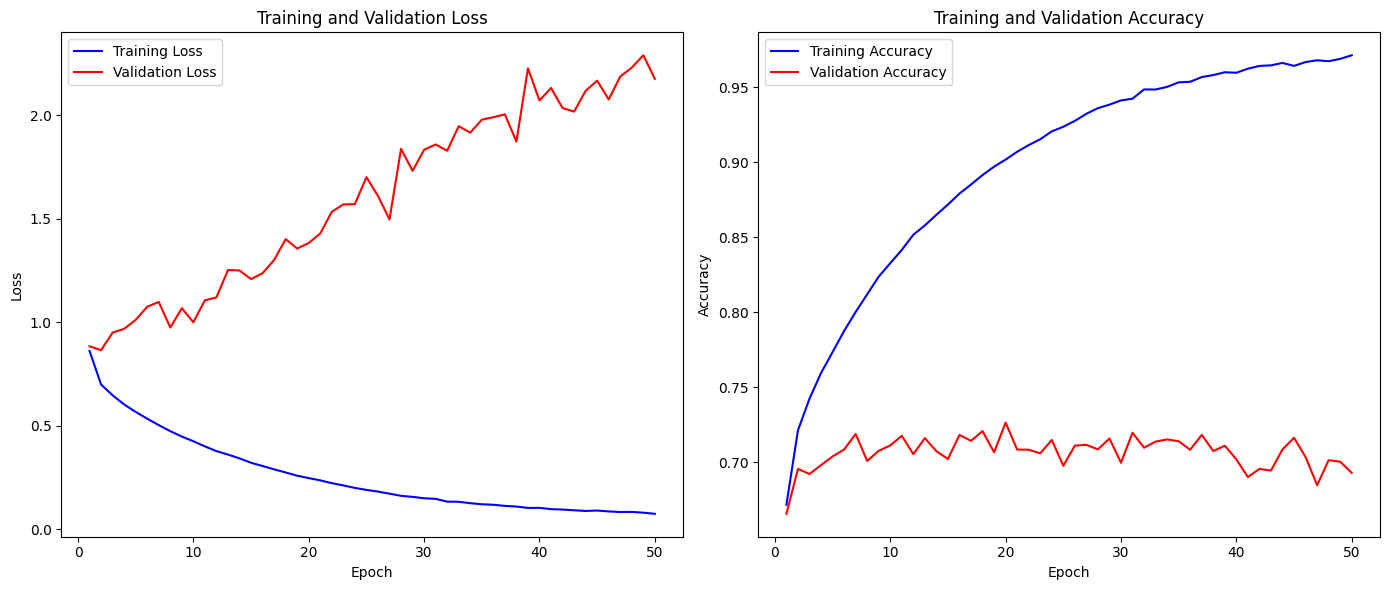

In [19]:
plot_performance(train_losses, val_losses, train_accuracies, val_accuracies)

In [20]:
predictions = learner.predict(test_dataset)

In [ ]:
#learner.load_state_dict(torch.load('best_adapter_model.pt'))
#learner.eval()

In [21]:
df_test_uses_merged['prediction'] = predictions

out_dir = 'answer/'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

answer_df = df_test_uses_merged[['identifier1', 'identifier2', 'language', 'prediction']].copy()

# Saving files per language
for language in answer_df["language"].unique():
    df_temp = answer_df[answer_df["language"] == language].drop('language', axis=1)
    df_temp['prediction'] = label_encoder.inverse_transform(df_temp['prediction'])
    df_temp.to_csv(f'{out_dir}{language}.tsv', index=False, sep='\t', quoting=csv.QUOTE_MINIMAL, quotechar='"')

with ZipFile('answer.zip', 'w') as zipf:
    for root, _, files in os.walk(out_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print("Saved answer.zip with predictions per language.")

Saved answer.zip with predictions per language.


In [17]:
df_temp['prediction'].value_counts()

prediction
4.0    854
1.0     11
2.0      4
3.0      2
Name: count, dtype: int64

In [22]:
def true_labels(df, ref):
  
    if not os.path.exists(ref):
        os.makedirs(ref)

    languages = df['language'].unique()

    for language in languages:
        lang_df = df[df['language'] == language][['identifier1', 'identifier2', 'median_cleaned']]

        lang_dir = os.path.join(ref, language)
        if not os.path.exists(lang_dir):
            os.makedirs(lang_dir)

        lang_file_path = os.path.join(lang_dir, 'labels.tsv')
        lang_df.to_csv(lang_file_path, sep='\t', index=False, quoting=csv.QUOTE_NONE)
        print(f"Saved truth labels for {language} at {lang_file_path}")

true_labels(df_test_uses_merged, 'ref')

Saved truth labels for norwegian at ref/norwegian/labels.tsv
Saved truth labels for german at ref/german/labels.tsv
Saved truth labels for chinese at ref/chinese/labels.tsv
Saved truth labels for spanish at ref/spanish/labels.tsv
Saved truth labels for english at ref/english/labels.tsv
Saved truth labels for russian at ref/russian/labels.tsv
Saved truth labels for swedish at ref/swedish/labels.tsv


In [14]:
class AdapterLayer(nn.Module):
    """
    Bottleneck adapter architecture following standard practices:
    - Down-project -> Non-linearity -> Up-project
    """
    def __init__(self, input_dim, bottleneck_dim, dropout_rate=0.1):
        super().__init__()
        self.down_project = nn.Linear(input_dim, bottleneck_dim)
        self.up_project = nn.Linear(bottleneck_dim, input_dim)
        self.layer_norm = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.down_project(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.up_project(x)
        x = self.dropout(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return x

class AdapterNetwork(nn.Module):
    def __init__(
        self,
        num_classes=4,
        embedding_dim=768,
        adapter_dim=64,  # Bottleneck dimension
        hidden_dims=[512, 256],
        dropout_rate=0.2
    ):
        super().__init__()

        # Adapter layers with bottleneck architecture
        self.adapter1 = AdapterLayer(
            input_dim=embedding_dim,
            bottleneck_dim=adapter_dim,
            dropout_rate=dropout_rate
        )

        self.adapter2 = AdapterLayer(
            input_dim=embedding_dim,
            bottleneck_dim=adapter_dim,
            dropout_rate=dropout_rate
        )

        # Calculate input dimensions
        combined_embedding_dim = embedding_dim * 2  # Concatenated adapted embeddings
        feature_dim = embedding_dim * 4 + 3  # From CustomDataset.create_features
        total_input_dim = combined_embedding_dim + feature_dim

        # Build classifier layers with skip connections
        self.classifier_layers = nn.ModuleList()
        input_dim = total_input_dim

        for hidden_dim in hidden_dims:
            self.classifier_layers.append(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.GELU(),
                    nn.Dropout(dropout_rate)
                )
            )
            input_dim = hidden_dim

        # Final classification layer
        self.final_layer = nn.Linear(input_dim, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, embedding1, embedding2, combined_features):
        # Apply adapters with residual connections
        adapted1 = self.adapter1(embedding1)
        adapted2 = self.adapter2(embedding2)

        # Concatenate adapted embeddings with combined features
        x = torch.cat([adapted1, adapted2, combined_features], dim=1)

        # Pass through classifier layers with skip connections
        for layer in self.classifier_layers:
            layer_output = layer(x)
            # Add skip connection if dimensions match
            if layer_output.shape == x.shape:
                x = layer_output + x
            else:
                x = layer_output

        # Final classification
        output = self.final_layer(x)

        return output

    def get_adapter_params(self):
        """Get only the adapter parameters for efficient fine-tuning"""
        adapter_params = []
        for name, param in self.named_parameters():
            if 'adapter' in name:
                adapter_params.append(param)
        return adapter_params

    def freeze_non_adapter_params(self):
        """Freeze all parameters except adapters for fine-tuning"""
        for name, param in self.named_parameters():
            if 'adapter' not in name:
                param.requires_grad = False